## VOXN19

### Using SVM_REG in SageMaker (Batch Transform)

 https://sagemaker.readthedocs.io/en/latest/ 
 
### General Outline
Typically, when using a notebook instance with SageMaker, you will proceed through the following steps. Of course, not every step will need to be done with each project. Also, there is quite a lot of room for variation in many of the steps, as you will see throughout these lessons.

- Download or otherwise retrieve the data.
- Process / Prepare the data.
- Upload the processed data to S3.
- Train a chosen model.
- Test the trained model (typically using a batch transform job).
- Deploy the trained model.
- Use the deployed model.

In this notebook we will only be covering step 5 as we just want to confirm the possibility of using our own model in sagemaker. 

In [1]:
# Make sure that we use SageMaker 1.x
#!pip install sagemaker==1.72.0

### Step 0: Setting up the notebook

We begin by setting up all of the necessary bits required to run our notebook. To start that means loading all of the Python modules we will need.

In [2]:
%matplotlib inline
import boto3
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import sys
import time
import json
from sklearn import metrics
from IPython.display import display
from time import strftime, gmtime
import sagemaker # SageMaker Python SDK
from sagemaker.predictor import csv_serializer
#import warnings
#warnings.filterwarnings('ignore')
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)

In addition to the modules above, we need to import the various bits of SageMaker that we will be using.

In [33]:
#bucket = 'electomedia'

#from sagemaker import get_execution_role
#from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

### Step 1: importing the testing data

In [3]:
strings = {'Sección' : 'str', 'cod_ccaa' : 'str', 'cod_prov' : 'str', 'cod_mun' : 'str'}

In [5]:
bucket_name = 'arn:aws:s3:::electomedia' 

prefix = 'electomedia/svm' #the complete path in front of the object name, which includes the bucket name. 
file_key = 'test_set_SVM_pc_VOX.txt'
batch-output='s3://electomedia/svm/batch-output'
s3uri = 's3://electomedia/svm/test_set_SVM_pc_VOX.txt'

df_eleccion = pd.read_csv(s3uri)

df_eleccion.head()

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,% PP,% PSOE,% UP,% Vox,% Cs,% IU,Ganador,Segundo,Tercero,Cuarto,Quinto,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
0,022019111010400101001,1,4,4001,400101001,Andalucía,Almería,Abla,1002,717,0.715569,7,710,3,707,193,310,47,30,0,122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,0.271831,0.436620,0.042254,0.171831,0.066197,0.0,PSOE,PP,VOX,Cs,UP,39.0,42.0,47.0,47.0,70.0,72.0,73.0,80.0,89.0,81.0,94.0,87.0,91.0,77.0,72.0,42.0,67.0,56.0,19.0,4.0,0.0,1249.0,635.0,614.0,0.269816,0.590072,0.140112,304.0,0.223684,0.243395,140.0,0.421429,0.550000,0.315315,9159.0,8788.0,20172.0,19546.0,5574.0,4833.0,3286.0,3082.0,403.0,471.0,"{'PP': 193, 'PSOE': 310, 'Cs': 47, 'UP': 30, 'IU': 0, 'VOX': 122, 'UPyD': 0, 'MP': 0, 'CiU': 0, 'ERC': 0, 'JxC': 0, 'CUP': 0, 'DiL': 0, 'PNV': 0, 'Bildu': 0, 'Amaiur': 0, 'CC': 0, 'FA': 0, 'TE': 0, 'BNG': 0, 'PRC': 0, 'GBai': 0, 'Compromis': 0, 'PACMA': 3, 'Otros': 2}","[('PSOE', 310), ('PP', 193), ('VOX', 122), ('Cs', 47), ('UP', 30), ('PACMA', 3), ('Otros', 2), ('IU', 0), ('UPyD', 0), ('MP', 0), ('CiU', 0), ('ERC', 0), ('JxC', 0), ('CUP', 0), ('DiL', 0), ('PNV', 0), ('Bildu', 0), ('Amaiur', 0), ('CC', 0), ('FA', 0), ('TE', 0), ('BNG', 0), ('PRC', 0), ('GBai', 0), ('Compromis', 0)]"
1,022019111010400201001,1,4,4002,400201001,Andalucía,Almería,Abrucena,1013,711,0.701876,12,699,1,698,111,349,45,42,0,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.158798,0.499285,0.060086,0.210300,0.064378,0.0,PSOE,VOX,PP,Cs,UP,30.0,30.0,33.0,41.0,71.0,79.0,60.0,75.0,70.0,70.0,108.0,101.0,99.0,86.0,61.0,64.0,61.0,46.0,14.0,2.0,1.0,1202.0,637.0,565.0,0.278702,0.609817,0.111481,298.0,0.251678,0.247920,179.0,0.379888,0.625698,0.375262,8827.0,8107.0,17841.0,17115.0,4640.0,4048.0,3418.0,2770.0,568.0,620.0,"{'PP': 111, 'PSOE': 349, 'Cs': 45, 'UP': 42, 'IU': 0, 'VOX': 147, 'UPyD': 0, 'MP': 0, 'CiU': 0, 'ERC': 0, 'JxC': 0, 'CUP': 0, 'DiL': 0, 'PNV': 0, 'Bildu': 0, 'Amaiur': 0, 'CC': 0, 'FA': 0, 'TE': 0, 'BNG': 0, 'PRC': 0, 'GBai': 0, 'Compromis': 0, 'PACMA': 2, 'Otros': 2}","[('PSOE', 349), ('VOX', 147), ('PP', 111), ('Cs', 45), ('UP', 42), ('PACMA', 2), ('Otros', 2), ('IU', 0), ('UPyD', 0), ('MP', 0), ('CiU', 0), ('ERC', 0), ('JxC', 0), ('CUP', 0), ('DiL', 0), ('PNV', 0), ('Bildu', 0), ('Amaiur', 0), ('CC', 0), ('FA', 0), ('TE', 0), ('BNG', 0), ('PRC', 0), ('GBai', 0), ('Compromis', 0)]"
2,022019111010400301001,1,4,4003,400301001,Andalucía,Almería,Adra,667,484,0.725637,7,477,5,472,176,128,15,34,0,116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0.368973,0.268344,0.071279,0.243187,0.031447,0.0,PP,PSOE,VOX,UP,Cs,36.0,28.0,44.0,40.0,63.0,64.0,54.0,54.0,54.0,61.0,82.0,75.0,67.0,48.0,37.0,40.0,26.0,15.0,3.0,1.0,0.0,892.0,435.0,457.0,0.190583,0.643498,0.165919,7968.0,0.382530,8.932735,2525.0,0.432871,0.473663,0.240637,8965.0,8267.0,26498.0,24688.0,5121.0,4795.0,2499.0,2301.0,337.0,333.0,"{'PP': 176, 'PSOE': 128, 'Cs': 15, 'UP': 34, 'IU': 0, 'VOX': 116, 'UPyD': 0, 'MP': 0, 'CiU': 0, 'ERC': 0, 'JxC': 0, 'CUP': 0, 'DiL': 0, 'PNV': 0, 'Bildu': 0, 'Amaiur': 0, 'CC': 0, 'FA': 0, 'TE': 0, 'BNG': 0, 'PRC': 0, 'GBai': 0, 'Compromis': 0, 'PACMA': 3, 'Otros': 0}","[('PP', 176), ('PSOE', 128), ('VOX', 116), ('UP', 34), ('Cs', 15), ('PACMA', 3), ('IU', 0), ('UPyD', 0), ('MP', 0), ('CiU', 0), ('ERC', 

In [13]:
#df_eleccion = pd.read_csv('gen_A19_unif_cols_prov_copia.txt', dtype = strings)
#df_eleccion = pd.read_csv('../test_set_SVM_pc_VOX.txt', dtype = strings)

In [13]:
#df_eleccion.head().T

In [14]:
#df_eleccion.columns

In [10]:
#df_eleccion['% Vox'].describe()

In [11]:
#df_eleccion['% Vox'].isna().sum()

In [1]:
#df_eleccion.loc[df_eleccion['% Vox'].isna()]

In [12]:
#df_eleccion['VOX'].sum()

In [2]:
#df_eleccion.info()

In [11]:
#añado CCAA y me cargo 0-4,5-9,10-14
cols_validas = ['% Vox','Sección','CCAA','Provincia',
        'Censo_Esc', 'Participación',
        '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015']

In [12]:
df_eleccion = df_eleccion[cols_validas]

In [3]:
#df_eleccion.info()

In [14]:
FillNA_num_mean = ['Censo_Esc', 'Participación','15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015']

In [15]:
for item in FillNA_num_mean:
        
    df_eleccion[item].fillna(df_eleccion[item].mean(), inplace=True)

In [16]:
categorical = ['Provincia']

In [4]:
#df_eleccion['Provincia'].value_counts().sum()

In [18]:
mean_map1 = {}
for c in categorical:
    
    # df_filtered[c].fillna(df_filtered[c].mode()[0], inplace=True)
    
    mean = df_eleccion.groupby(c)['% Vox'].mean()
    df_eleccion[c] = df_eleccion[c].map(mean)    
    mean_map1[c] = mean

In [5]:
#mean_map1

In [20]:
categorical2 = ['CCAA']

In [9]:
#categorical2

In [22]:
mean_map2 = {}
for c in categorical2:
    
    # df_filtered[c].fillna(df_filtered[c].mode()[0], inplace=True)
    
    mean = df_eleccion.groupby(c)['% Vox'].mean()
    df_eleccion[c] = df_eleccion[c].map(mean)    
    mean_map2[c] = mean

In [6]:
#mean_map2

In [26]:
df_eleccion = df_eleccion.drop(['Renta persona 2015', 'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Pensiones 2015', 'Renta Desempleo 2015', 'Hombres', 'Mujeres'], axis = 1)

In [8]:
#df_eleccion['% Vox'].isna().sum() #por qué no lo hemos sustituido por la media?

In [28]:
df_eleccion = df_eleccion[df_eleccion['% Vox'].notnull()]

In [ ]:
df_eleccion.info()

In [ ]:
#datos limpios y numéricos. 

In [ ]:
# URI where a pre-trained model is stored
#model_url = 's3://{}/{}'.format(bucket,key)
model_url= 's3://electomedia/svm/model.tar.gz'
model_name = "SVM_reg" # user-defined model name

### Step 5: Test the model
Now that we have fit our model to the training data, using the validation data to avoid overfitting, we can test our model. To do this we will make use of SageMaker's Batch Transform functionality. To start with, we need to build a transformer object from our fit model.

In [51]:
#svm_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
#svm_transformer = sagemaker.transformer.Transformer(instance_count = 1, instance_type = 'ml.t2.medium')
svm_transformer = SVM_reg.transformer.Transformer(instance_count = 1, instance_type = 'ml.t2.medium',output_path=batch-output)

#svm_transformer.transform(test_location, content_type='text/csv', split_type='Line', input_filter="$[2:]", join_source= "Input", output_filter="$")

svm_transformer.transform(data= df_eleccion, content_type='text/csv', split_type='Line', input_filter="$[2:]", join_source= "Input", output_filter="$")

Next we ask SageMaker to begin a batch transform job using our trained model and applying it to the test data we previously stored in S3. We need to make sure to provide SageMaker with the type of data that we are providing to our model, in our case text/csv, so that it knows how to serialize our data. In addition, we need to make sure to let SageMaker know how to split our data up into chunks if the entire data set happens to be too large to send to our model all at once.

Note that when we ask SageMaker to do this it will execute the batch transform job in the background. Since we need to wait for the results of this job before we can continue, we use the wait() method. An added benefit of this is that we get some output from our batch transform job which lets us know if anything went wrong.

In [58]:
#xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
#xgb_transformer.transform(test_location1, join_source= "Input",content_type="text/csv")

In [62]:
svm_transformer.wait()

.................Arguments: serve
[2021-08-26 16:39:53 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-08-26 16:39:53 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-08-26 16:39:53 +0000] [1] [INFO] Using worker: gevent
[2021-08-26 16:39:53 +0000] [20] [INFO] Booting worker with pid: 20
[2021-08-26 16:39:53 +0000] [21] [INFO] Booting worker with pid: 21
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)']. 
  monkey.patch_all(subprocess=True)
[2021-08-26:16:39:53:INFO

Now that the batch transform job has finished, the resulting output is stored on S3. Since we wish to analyze the output inside of our notebook we can use a bit of notebook magic to copy the output file from its S3 location and save it locally.

In [63]:
!aws s3 cp --recursive $svm_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-550102314018/xgboost-2021-08-26-16-34-24-368/test.csv.out to data/N19/test.csv.out


To see how well our model works we can create a simple scatter plot between the predicted and actual values. If the model was completely accurate the resulting scatter plot would look like the line $x=y$. As we can see, our model seems to have done okay but there is room for improvement.

In [76]:
#Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

Text(0.5, 1.0, 'Median vote percentage vs Predicted vote percentage')

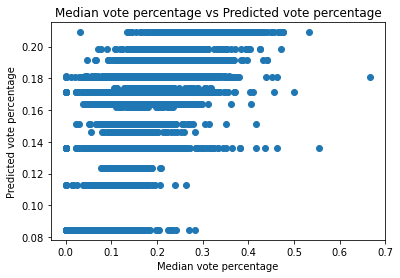

In [79]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median vote percentage")
plt.ylabel("Predicted vote percentage")
plt.title("Median vote percentage vs Predicted vote percentage")